In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.manifold import TSNE

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Carregando os dados
df = pd.read_csv('versao_2_spotify_songs.csv')

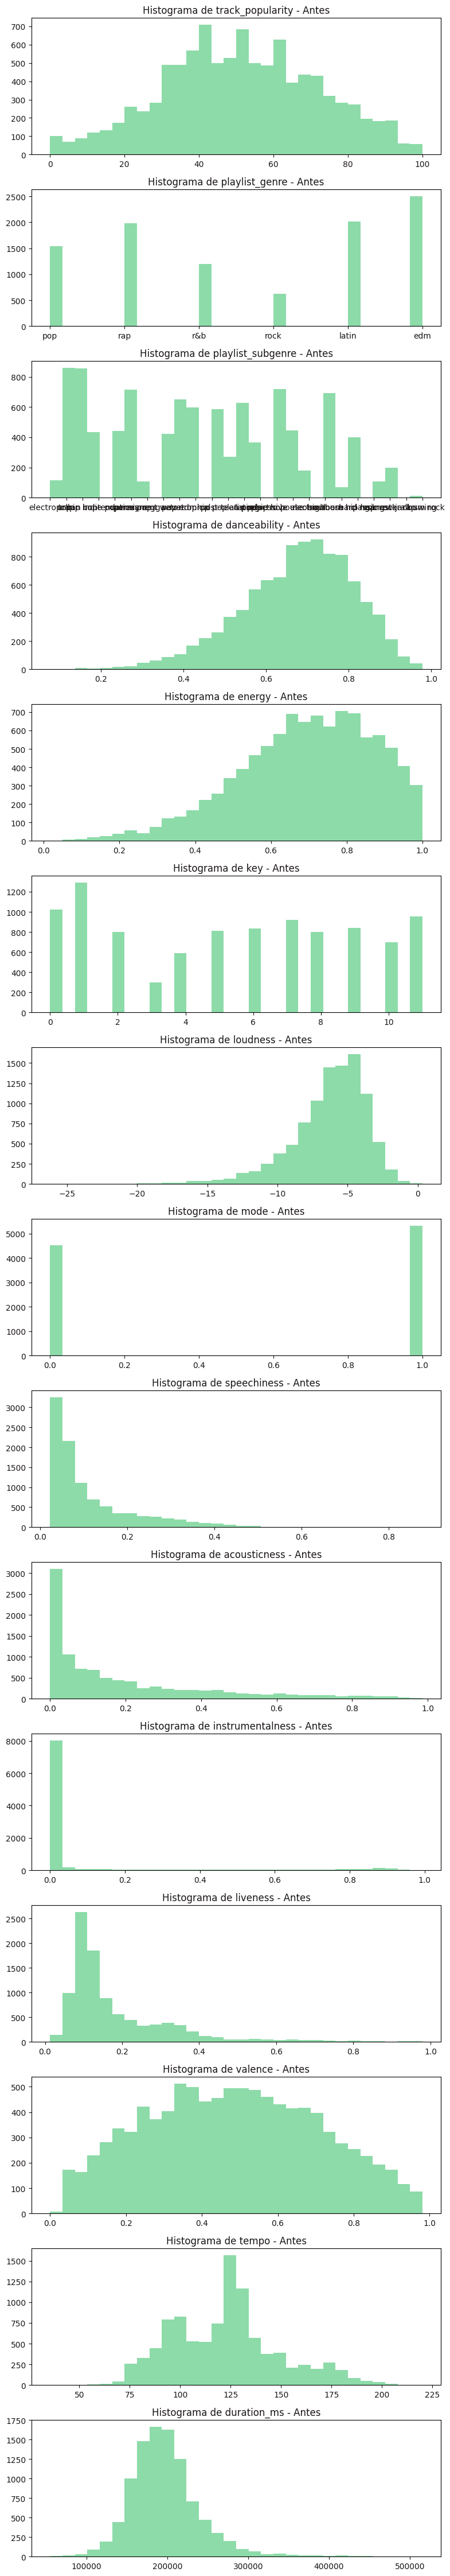

In [3]:
cor_letras = '#191414'
cor_grafico = '#1DB954'

features_antes = df.columns


num_plots_antes = len(features_antes)
fig_antes, axs_antes = plt.subplots(
    num_plots_antes, 1, figsize=(8, num_plots_antes * 3)
)


for i, feature in enumerate(features_antes):
    axs_antes[i].hist(df[feature], bins=30, alpha=0.5, color=cor_grafico)
    axs_antes[i].set_title(f"Histograma de {feature} - Antes", color=cor_letras)

    axs_antes[i].tick_params(axis="x", colors=cor_letras)
    axs_antes[i].tick_params(axis="y", colors=cor_letras)

    axs_antes[i].xaxis.label.set_color(cor_letras)
    axs_antes[i].yaxis.label.set_color(cor_letras)

plt.tight_layout()
plt.show()

In [4]:
df.head(5)

,track_popularity,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,7,pop,electropop,0.665,0.600,11,-7.396,0,0.0344,0.0103,0.455000,0.0928,0.595,102.002,247920
1,48,rap,trap,0.620,0.590,5,-8.289,0,0.0497,0.3420,0.000000,0.0958,0.270,160.026,192000
2,2,rap,trap,0.703,0.376,6,-17.772,0,0.0752,0.2780,0.000000,0.0540,0.650,140.015,213618
3,4,rap,hip hop,0.583,0.527,11,-7.876,1,0.0733,0.7150,0.000007,0.1540,0.395,97.346,187036
4,0,rap,trap,0.594,0.393,5,-10.027,0,0.0809,0.2220,0.000002,0.0941,0.425,106.821,303073


## Distribuição Estatística Básica de Colunas Numéricas:

In [5]:
df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000,9864.000000
mean,51.014700,0.677046,0.694594,5.384935,-6.332683,0.540856,0.114036,0.191314,0.094708,0.185373,0.481255,122.282934,197699.036496
std,20.827159,0.135529,0.178268,3.641122,2.762310,0.498353,0.101200,0.225486,0.239161,0.146677,0.225913,26.686579,44754.763629
min,0.000000,0.077100,0.016700,0.000000,-26.207000,0.000000,0.023000,0.000001,0.000000,0.013100,0.000010,35.477000,54656.000000
25%,37.000000,0.592000,0.580000,2.000000,-7.614000,0.000000,0.044775,0.018875,0.000000,0.095300,0.307000,100.377000,170057.500000
50%,50.000000,0.691000,0.712000,6.000000,-5.858500,1.000000,0.071700,0.101000,0.000009,0.125000,0.478000,123.951500,192839.000000
75%,66.000000,0.775000,0.831000,9.000000,-4.458000,1.000000,0.146000,0.288000,0.004320,0.231000,0.654000,135.819250,218182.000000
max,100.000000,0.979000,1.000000,11.000000,0.326000,1.000000,0.877000,0.986000,0.994000,0.979000,0.981000,219.991000,515703.000000


## Correlações entre Variáveis Numéricas:

In [6]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_columns.corr()


In [7]:
numeric_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

correlation_table = df[numeric_columns].apply(lambda x: x.corr(df['track_popularity']))
print(correlation_table)


danceability        0.166427
energy             -0.144650
key                 0.035898
loudness            0.107469
mode               -0.005435
speechiness         0.098723
acousticness        0.087666
instrumentalness   -0.216394
liveness           -0.068241
valence             0.137542
tempo              -0.034126
dtype: float64


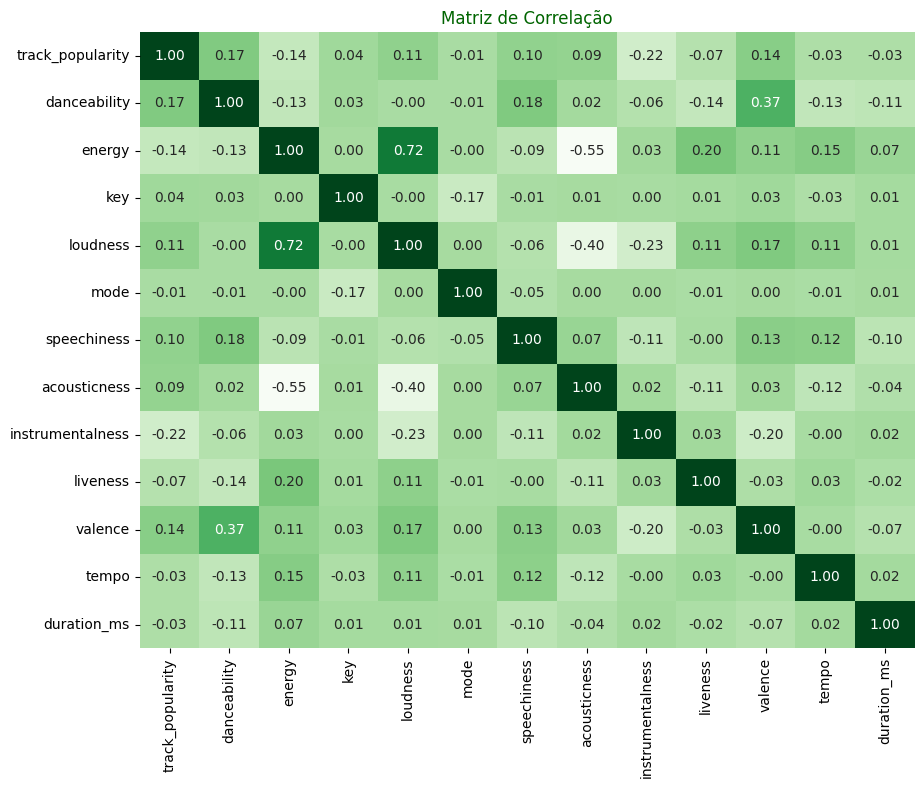

In [8]:
# Exibindo a matriz de correlação em um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f', cbar=False)  # Alterei o cmap para 'Greens' e removi a barra de cores (cbar=False)
plt.title('Matriz de Correlação', color='darkgreen')  # Ajustei a cor do título para verde escuro
plt.show()


## Popularidade Média por Classe de Popularidade:

In [9]:
def classify_popularity(popularity):
    if popularity <= 20:
        return 0
    elif popularity <= 40:
        return 1
    elif popularity <= 60:
        return 2
    else:
        return 3

df['popularity_class'] = df['track_popularity'].apply(classify_popularity)

In [10]:
# Calculando a média da popularidade por classe de popularidade
media_popularidade = df.groupby('popularity_class')['track_popularity'].mean()
print(media_popularidade)

popularity_class
0    11.967611
1    32.606478
2    50.322302
3    74.271597
Name: track_popularity, dtype: float64


### Normalização de Dados:


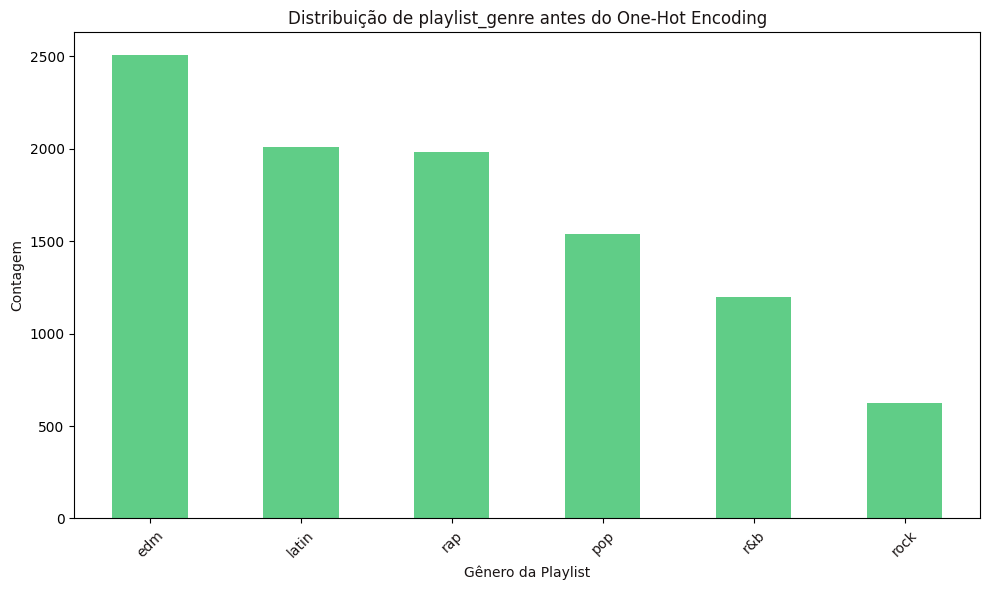

In [11]:
# Plot do gráfico antes do One-Hot Encoding
plt.figure(figsize=(10, 6))  # Define o tamanho da figura
df['playlist_genre'].value_counts().plot(kind='bar', color= cor_grafico, alpha=0.7)  # Plota o gráfico de barras com a contagem dos gêneros de playlist, usando a cor #1DB954 e transparência de 0.7
plt.title('Distribuição de playlist_genre antes do One-Hot Encoding', color=cor_letras)  # Define o título do gráfico com a cor #191414
plt.xlabel('Gênero da Playlist', color='#191414')  # Define o rótulo do eixo x com a cor #191414
plt.ylabel('Contagem', color='#191414')  # Define o rótulo do eixo y com a cor #191414
plt.xticks(rotation=45, color='#191414')  # Rotaciona os rótulos do eixo x para melhor visualização e define a cor #191414
plt.tight_layout()  # Melhora a disposição dos elementos no gráfico
plt.show()  # Mostra o gráfico


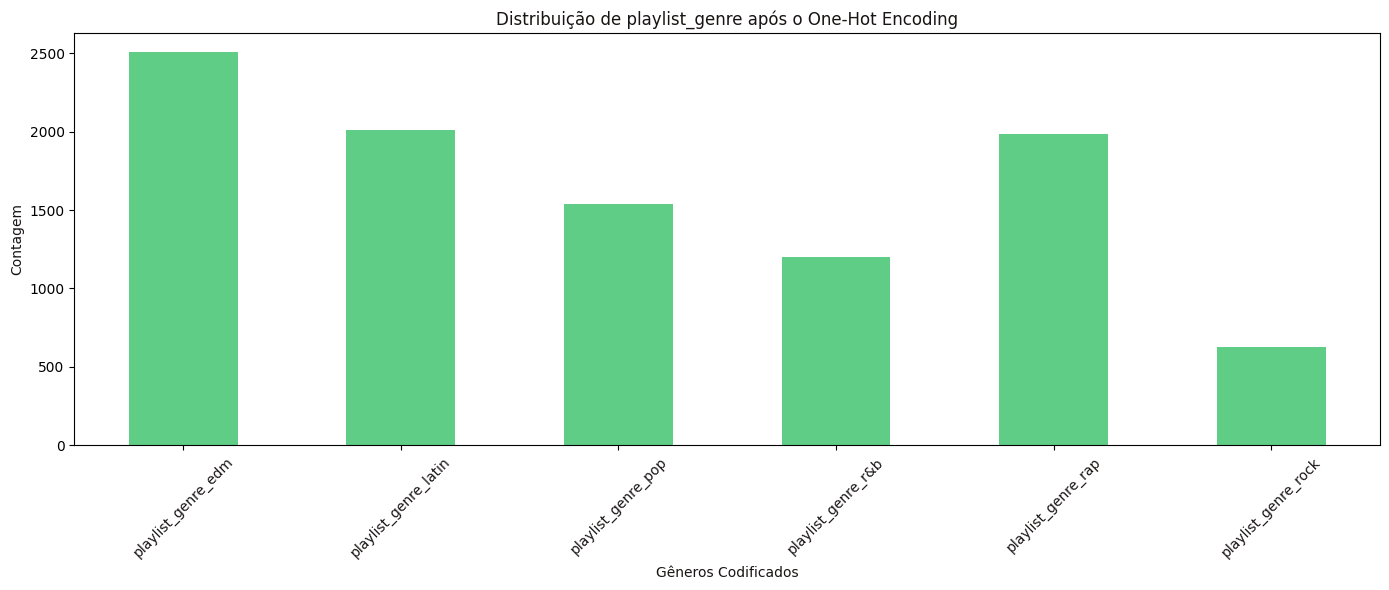

In [12]:
# Aplicando o One-Hot Encoding
df = pd.get_dummies(df, columns=['playlist_genre', 'playlist_subgenre'])

# Plot depois da codificação
plt.figure(figsize=(14, 6))
df.filter(regex='playlist_genre_').sum().plot(kind='bar', color='#1DB954', alpha=0.7)
plt.title('Distribuição de playlist_genre após o One-Hot Encoding', color='#191414')
plt.xlabel('Gêneros Codificados', color='#191414')
plt.ylabel('Contagem', color='#191414')
plt.xticks(rotation=45, color='#191414')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Melhora a disposição dos elementos no gráfico
plt.show() # Realiza o One-Hot Encoding nos dados de acordo com as colunas especificadas


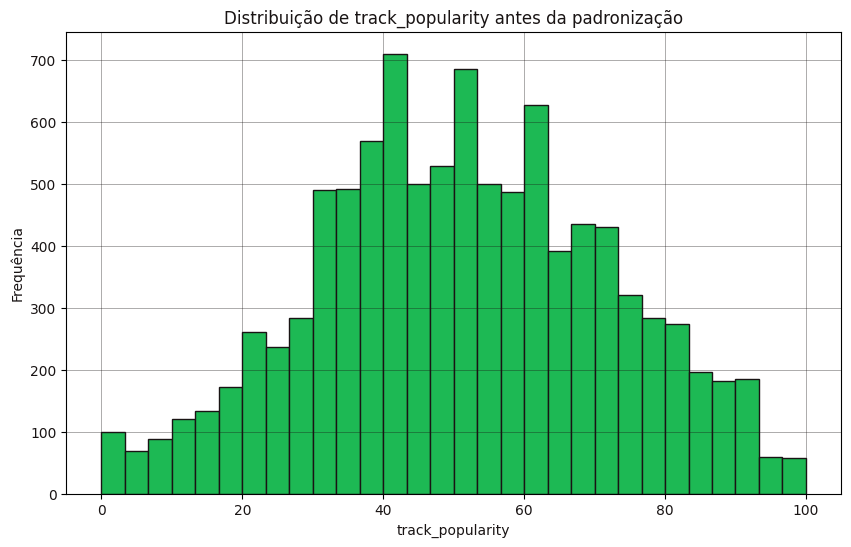

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['track_popularity'], bins=30, color=cor_grafico, edgecolor=cor_letras)
plt.title('Distribuição de track_popularity antes da padronização', color=cor_letras)
plt.xlabel('track_popularity', color=cor_letras)
plt.ylabel('Frequência', color=cor_letras)
plt.xticks(color=cor_letras)
plt.yticks(color=cor_letras)
plt.grid(color=cor_letras, linestyle='-', linewidth=0.5, alpha=0.5)
plt.show()


In [14]:
# Aplicando a padronização somente nas colunas numéricas
colunas_numericas = ['track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

scaler = StandardScaler()

df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

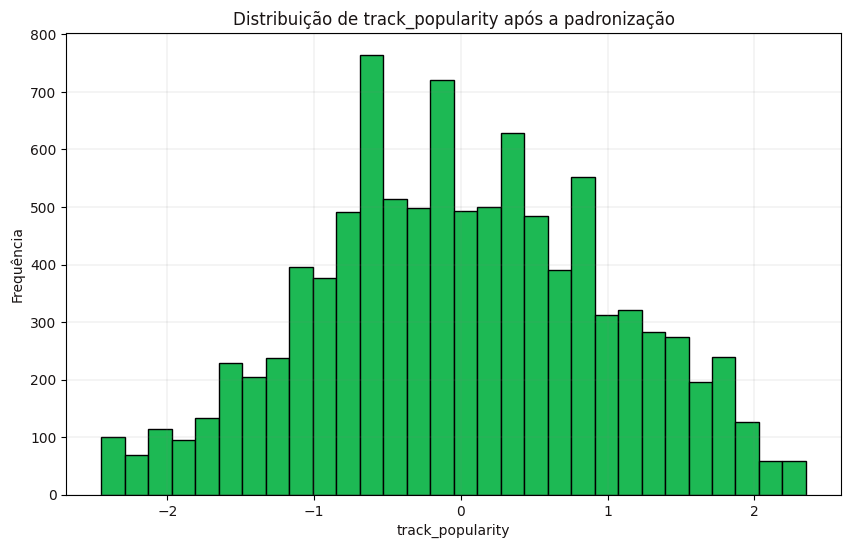

In [15]:
# Plot depois da padronização
plt.figure(figsize=(10, 6))
df['track_popularity'].plot(kind='hist', bins=30, color='#1DB954', edgecolor='black')
plt.title('Distribuição de track_popularity após a padronização', color='#191414')
plt.xlabel('track_popularity', color='#191414')
plt.ylabel('Frequência', color='#191414')
plt.xticks(color='#191414')
plt.yticks(color='#191414')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

### Remoção de Outliers:

In [16]:
# Definindo as colunas numéricas
colunas_numericas = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Calcula z-score para cada coluna numérica
z_scores = stats.zscore(df[colunas_numericas])

# Define um limite de z-score para considerar outliers (exemplo: 3)
limite_z_score = 3

# Encontra índices dos outliers em cada coluna
outliers_indices = (np.abs(z_scores) > limite_z_score).any(axis=1)

# Remove os outliers
df = df[~outliers_indices]


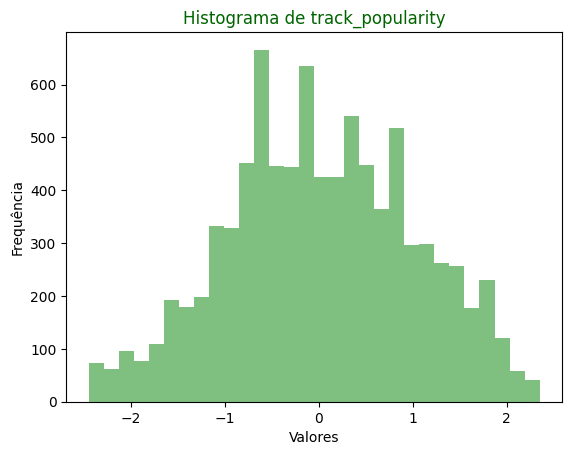

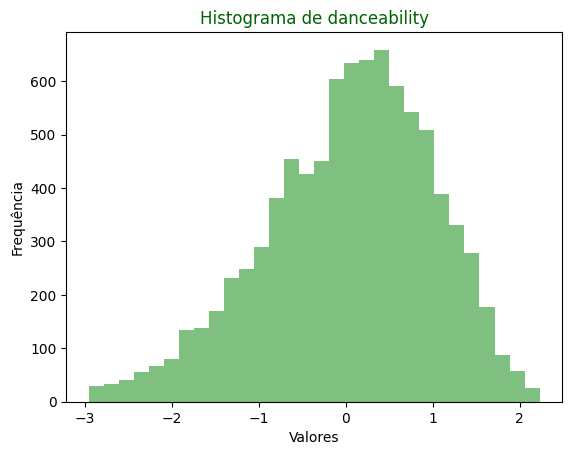

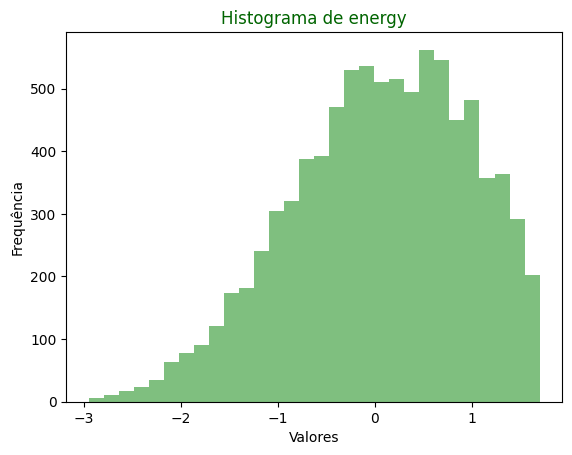

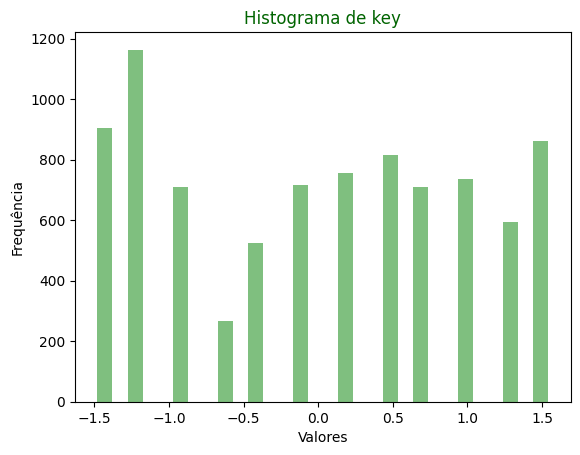

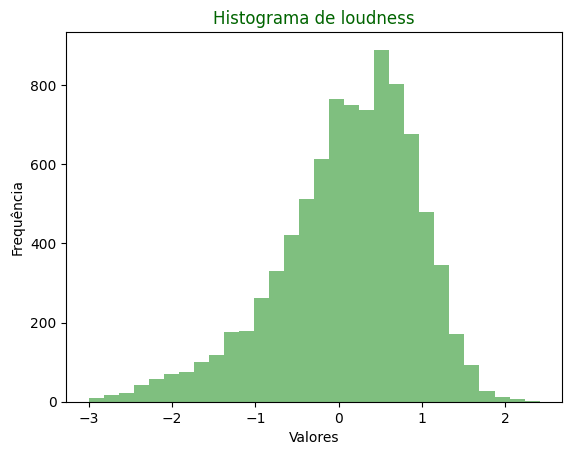

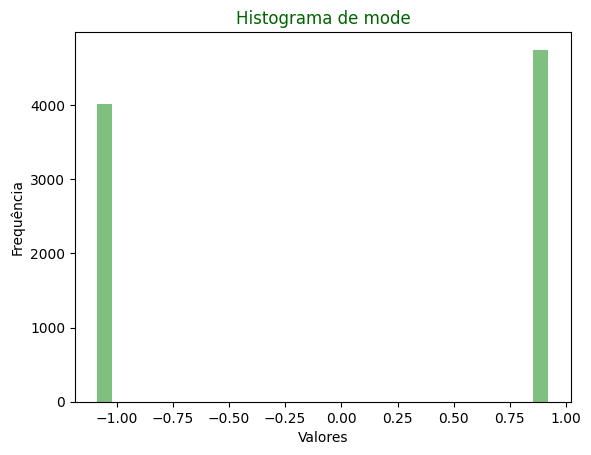

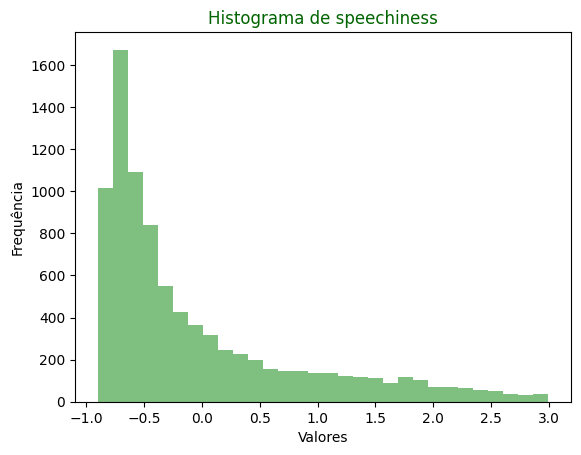

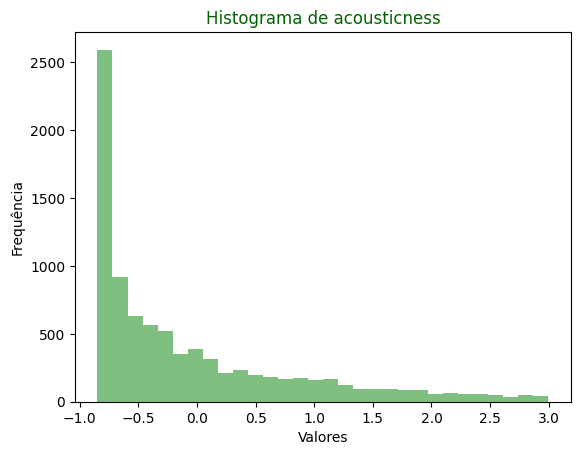

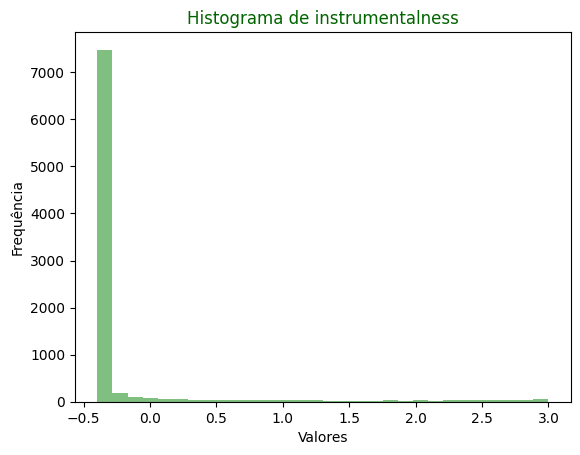

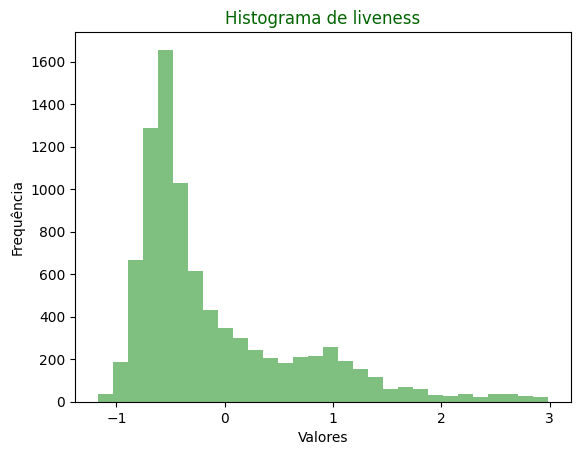

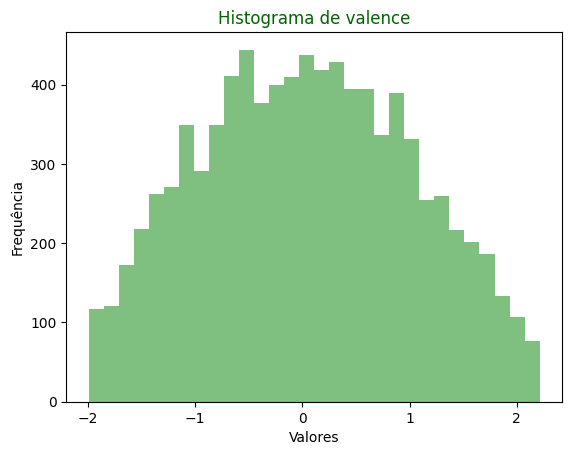

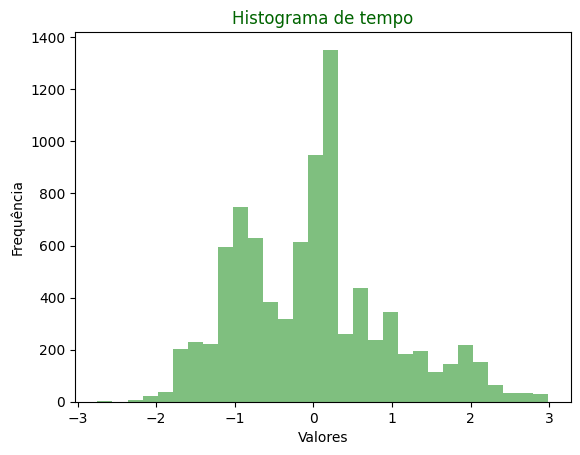

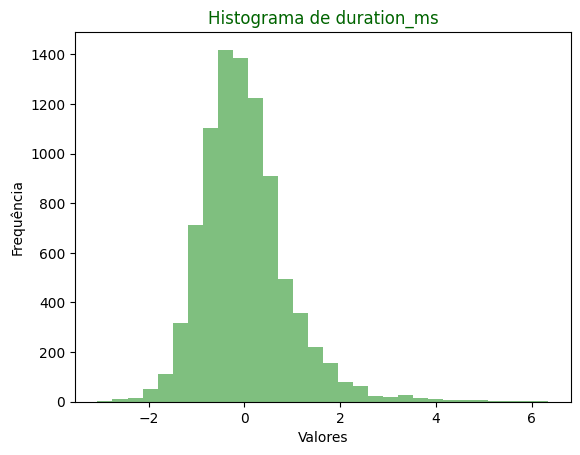

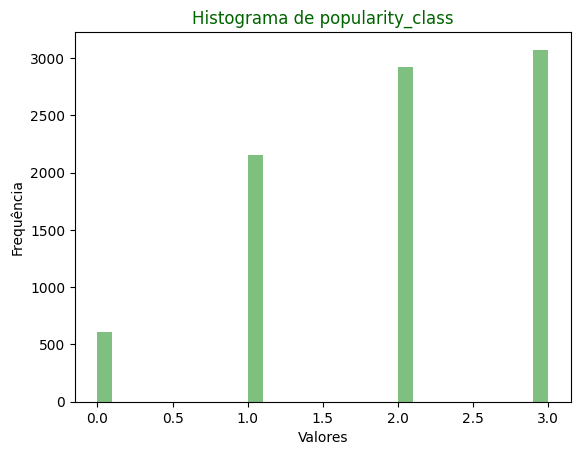

In [17]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    plt.hist(df[col], bins=30, alpha=0.5, color='green')  # Alterando a cor para tons de verde
    plt.title(f'Histograma de {col}', color='darkgreen')  # Título em tons de verde escuro
    plt.xlabel('Valores')  # Adicionando rótulo para o eixo x
    plt.ylabel('Frequência')  # Adicionando rótulo para o eixo y
    plt.show()



In [18]:
nome_arquivo = 'versao_3_spotify_songs.csv'
df.to_csv(nome_arquivo, index=False)
df = pd.read_csv(nome_arquivo,encoding='utf-8', sep = ',',index_col=0)